# Import needed modules

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create needed functions

## Functions to Create Data Frame from Dataset

#### **Function to create data frame**

In [2]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # check the folders from main directory. If there are another files, ignore them
        if pathlib.Path(foldpath).suffix != '':
            continue

        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            # check if there are another folders
            if pathlib.Path(foldpath).suffix == '':
                # check unneeded masks
                if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                    continue

                else:
                    o_file = os.listdir(fpath)
                    for f in o_file:
                        ipath = os.path.join(fpath, f)
                        filepaths.append(ipath)
                        labels.append(fold)

            else:            
                filepaths.append(fpath)
                labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

#### Function to generate images from dataframe

In [3]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [4]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks** 
<br> 
Callbacks : Helpful functions to help optimize model training  <br> 
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

#### **Function to plot history of training**

In [6]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### **Function to create Confusion Matrix**

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# **Model Structure**

#### **Start Reading Dataset**

In [8]:
data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 16
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


#### **Display Image Sample**

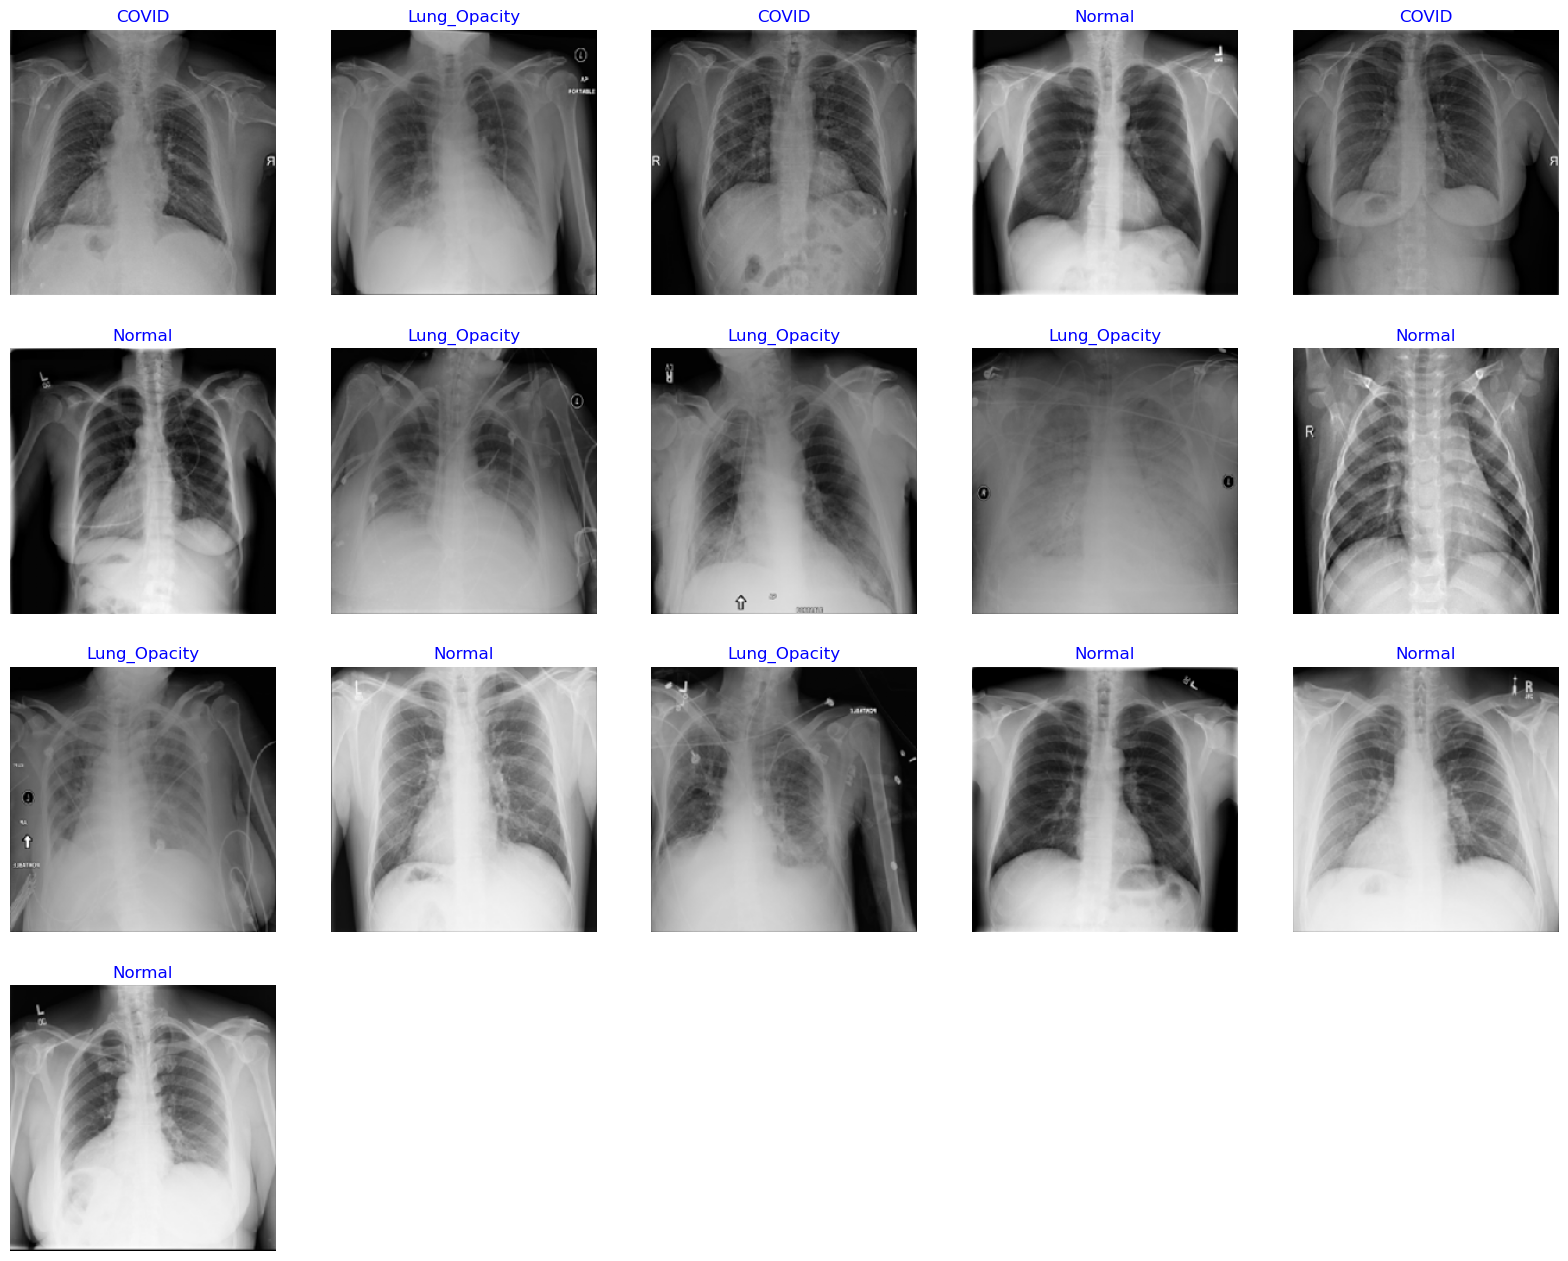

In [9]:
show_images(train_gen)

#### **Generic Model Creation**

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.densenet.DenseNet169(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

51877672/51877672 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 dense (Dense)               (None, 4)                 6660      
                                                                 
Total params: 12,649,540
Trainable params: 12,491,140
Non-trainable params: 158,400
_________________________________________________________________


#### **Set Callback Parameters**

In [11]:
batch_size = 16   # set batch size for training
epochs = 100   # number of all epochs in training
patience = 3   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 10   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

#### **Train model**

In [12]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?


 y


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /100    0.571   85.371   0.26826  91.919   0.00100  0.00100  accuracy     0.00    274.55  
 2 /100    0.276   91.247   0.45417  86.578   0.00100  0.00100  val_loss    -69.30   166.24  
 3 /100    0.225   92.316   1.02489  77.694   0.00100  0.00100  val_loss   -282.05   165.61  
 4 /100    0.184   93.681   0.27587  92.013   0.00100  0.00050  val_loss    -2.84    166.14  
 5 /100    0.115   95.866   0.17146  94.187   0.00050  0.00050  val_loss    36.08    166.27  
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 10
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /100    0.090   96.805   0.16277  94.802   0.00050  0.00050  val_loss     5.07    166.24  
 7 /100    0.075   97.419   0.19094  93.526   0.00050  0.00050  val_loss    -17.31   166.14  
 8 /100    0.064   97.773   0.18703  93.856   0.00050  0.00050  val_loss    -14.90   165.61  
 9 /100    0.051   98.104   0.24816  91.919   0.00050  0.00025  val_loss    -52.46   165.28  
10 /100    0.026   99.144   0.17950  94.943   0.00025  0.00025  val_loss    -10.27   166.00  
enter H to halt training or an integer for number of epochs to run then ask again


 H


training has been halted at epoch 10 due to user input
training elapsed time was 0.0 hours, 31.0 minutes, 14.14 seconds)


#### **Display model performance**

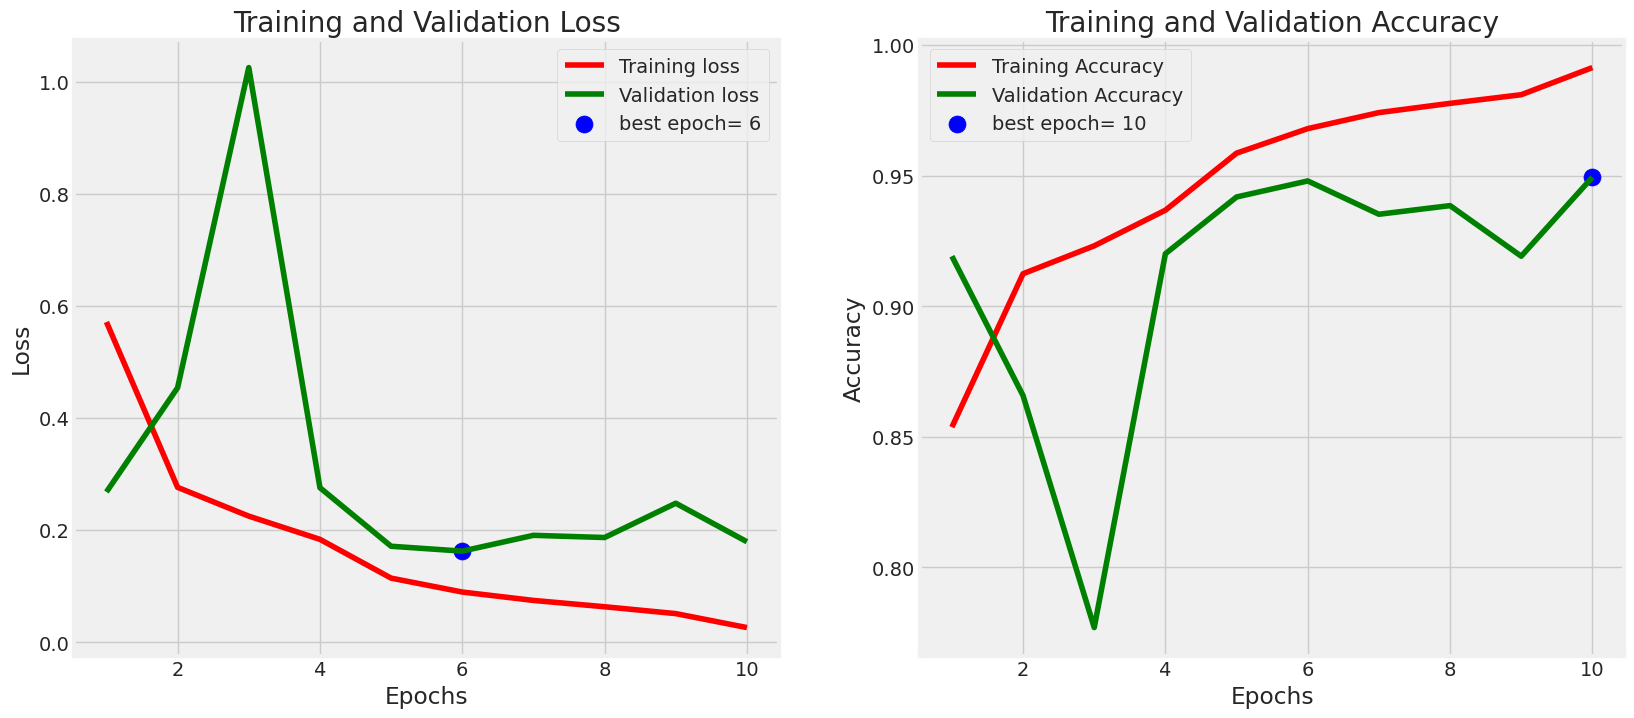

In [13]:
plot_training(history)

# **Evaluate model**

In [14]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

29/29 [==============================] - 25s 828ms/step - loss: 0.1195 - accuracy: 0.9594
Train Loss:  0.0473015196621418
Train Accuracy:  0.9806034564971924
--------------------
Validation Loss:  0.1815403550863266
Validation Accuracy:  0.9504310488700867
--------------------
Test Loss:  0.1195145845413208
Test Accuracy:  0.9593764543533325


# **Get Predictions**

In [15]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[1 1 1 ... 2 2 2]


#### **Confusion Matrics and Classification Report**

Confusion Matrix, Without Normalization
[[351   7   3   1]
 [  1 565  36   0]
 [  1  30 982   6]
 [  0   0   1 133]]
                 precision    recall  f1-score   support

          COVID       0.99      0.97      0.98       362
   Lung_Opacity       0.94      0.94      0.94       602
         Normal       0.96      0.96      0.96      1019
Viral Pneumonia       0.95      0.99      0.97       134

       accuracy                           0.96      2117
      macro avg       0.96      0.97      0.96      2117
   weighted avg       0.96      0.96      0.96      2117



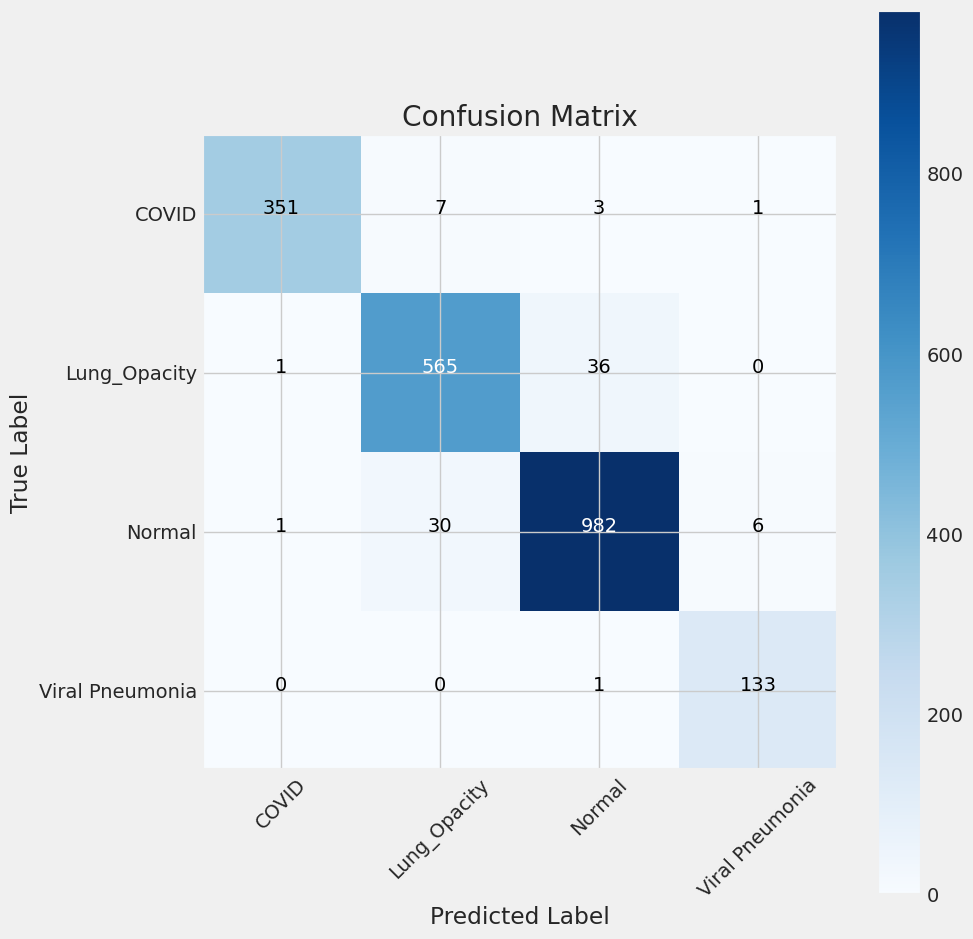

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

#### **Save model**

In [17]:
model_name = model.input_names[0][:-6]
subject = 'Covid-19'
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as densenet169-Covid-19-95.94.h5
weights were saved as densenet169-Covid-19-weights.h5


In [19]:
import os

# Get absolute paths for model and weights
print("Model saved at:", os.path.abspath('densenet169-Covid-19-95.94.h5'))
print("Weights saved at:", os.path.abspath('densenet169-Covid-19-weights.h5'))


Model saved at: /kaggle/working/densenet169-Covid-19-95.94.h5
Weights saved at: /kaggle/working/densenet169-Covid-19-weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [18]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Covid-19-class_dict.csv


In [20]:
import os

# Get absolute path for the class CSV file
csv_file_path = 'Covid-19-class_dict.csv'
print("Class CSV file saved at:", os.path.abspath(csv_file_path))


Class CSV file saved at: /kaggle/working/Covid-19-class_dict.csv


In [37]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Reading 

import os
from glob import glob
from PIL import Image

# Data Processing 

import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Data Modeling & Model Evaluation

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

# Grad-CAM

import keras
import matplotlib.cm as cm

In [42]:
files = ['Normal', 'COVID', 'Lung_Opacity','Viral Pneumonia']
path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(data_dir, level+'/'+'images')):
#         data.append(['{}/{}'.format(level, file), level])
        data.append([level +'/' +'images'+ '/'+file, level])
        

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' +data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'})

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-859.png,Normal,../input/covid19-radiography-database/COVID-19...
1,Normal/images/Normal-158.png,Normal,../input/covid19-radiography-database/COVID-19...
2,Normal/images/Normal-10121.png,Normal,../input/covid19-radiography-database/COVID-19...
3,Normal/images/Normal-1811.png,Normal,../input/covid19-radiography-database/COVID-19...
4,Normal/images/Normal-97.png,Normal,../input/covid19-radiography-database/COVID-19...


In [43]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))


Number of Duplicated Samples: 0
Number of Total Samples: 21165


In [44]:
no_of_samples = 21165
df = pd.DataFrame()
df['corona_result'] = ['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']
df['Count'] = [len(data[data['corona_result'] == 'Normal']), len(data[data['corona_result'] == 'Covid_positive']), len(data[data['corona_result'] == 'Lung_Opacity']), len(data[data['corona_result'] == 'Viral_Pneumonia'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result",  width = 600, 
             color_continuous_scale='BrBg')

fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

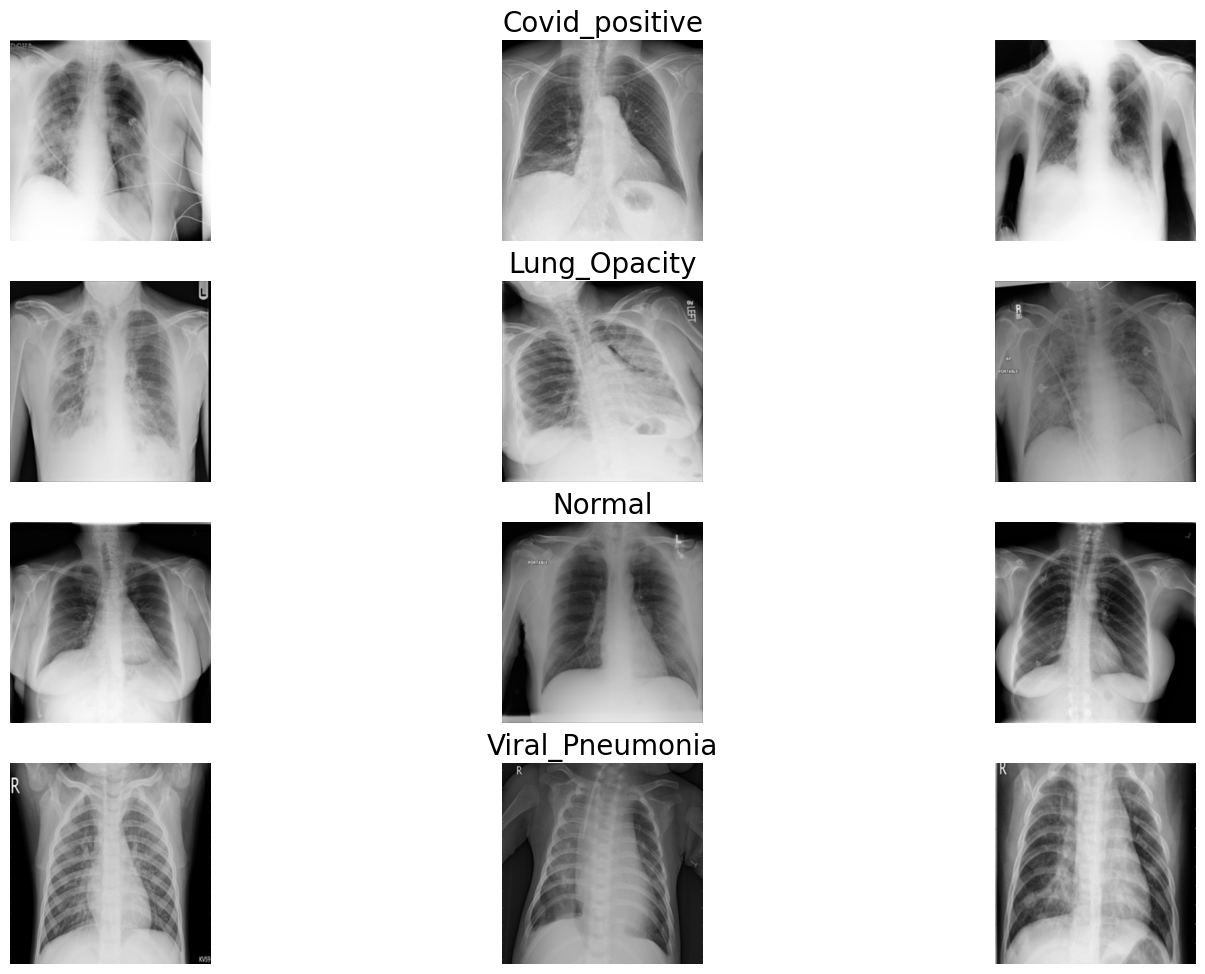

In [46]:
n_samples = 3

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 20)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')


In [47]:
def random_analysis(image_path):

    image = cv2.imread(image_path)

    # create figure
    fig = plt.figure(figsize=(10, 7))

    # setting values to rows and column variables
    rows = 2
    columns = 3

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)
    plt.title('Original ', fontsize = 14)

    plt.imshow(image)
    plt.axis('off')


    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # showing image
    plt.title('B channel', fontsize = 14)
    plt.imshow(image[ : , : , 0])
    plt.axis('off');


    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 3)

    img = cv2.imread(image_path)
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    plt.title("Ben Graham's Method", fontsize = 14)
    plt.imshow(img)
    plt.axis('off')
    
    list_text = image_path.split("/")

    print("\n-----------------------------{}-----------------------------\n".format("IMAGE DETAILS" + " ( " + list_text[5].upper() + " )"))

    print('Image Shape: {}'.format(image.shape))
    print('Image Height: {}'.format(image.shape[0]))
    print('Image Width: {}'.format(image.shape[1]))
    print('Image Dimension: {}'.format(image.ndim))
    print('Image Size: {}kb'.format(image.size//1024))
    print('Image Data Type: {}'.format(image.dtype))
    print('Maximum RGB value of the image: {}'.format(image.max()))
    print('Minimum RGB value of the image: {}'.format(image.min()))

In [48]:
list_images_sample = ["/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1003.png",
                     "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10004.png",
                     "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1000.png",
                     "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-100.png"]


-----------------------------IMAGE DETAILS ( VIRAL PNEUMONIA )-----------------------------

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 243
Minimum RGB value of the image: 0


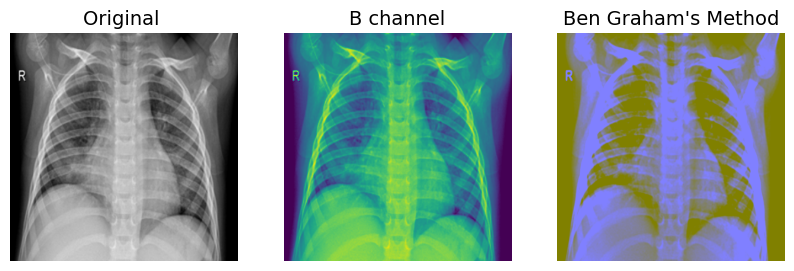

In [49]:
random_analysis(list_images_sample[0])


-----------------------------IMAGE DETAILS ( NORMAL )-----------------------------

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 250
Minimum RGB value of the image: 0


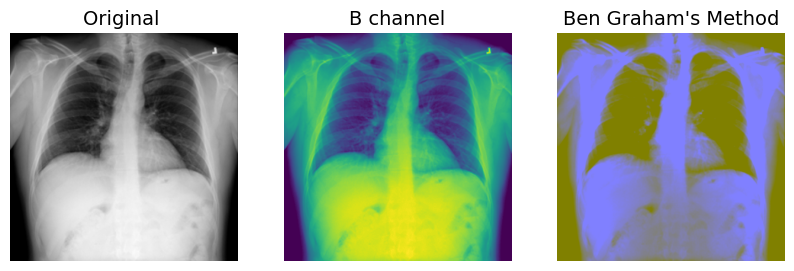

In [50]:
random_analysis(list_images_sample[1])


-----------------------------IMAGE DETAILS ( LUNG_OPACITY )-----------------------------

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 224
Minimum RGB value of the image: 0


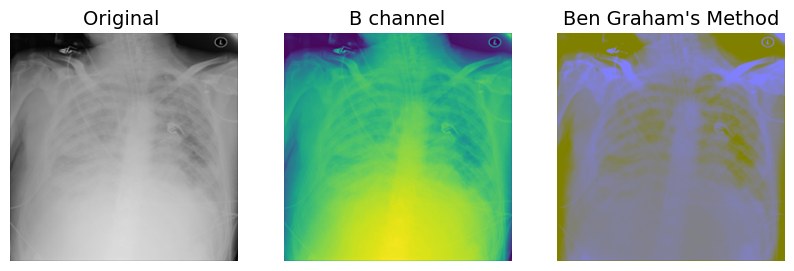

In [51]:
random_analysis(list_images_sample[2])


-----------------------------IMAGE DETAILS ( COVID )-----------------------------

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 0


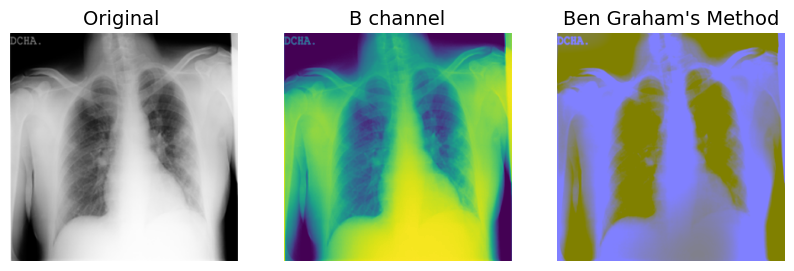

In [52]:
random_analysis(list_images_sample[3])

In [54]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, axis = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        axis[i // ncols][i % ncols].imshow(img)
        axis[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()


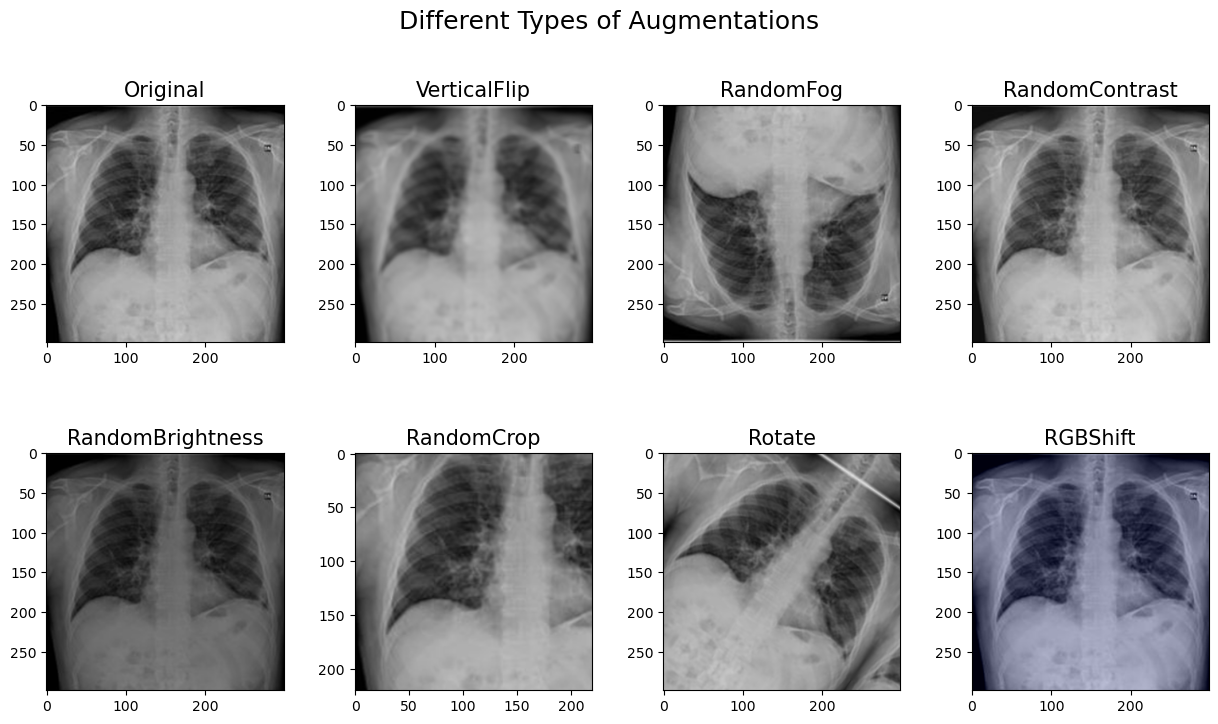

In [55]:
chosen_image = cv2.imread("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-101.png")

albumentation_list = [A.RandomFog(p = 1),A.VerticalFlip(p = 1), A.RandomBrightness(p = 1),A.RandomContrast(limit = 0.6, p = 1),
                      A.RandomCrop(p = 1,height = 220, width = 220),
                      A.Rotate(p = 1, limit = 90), A.RGBShift(p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original", "VerticalFlip", "RandomFog", "RandomContrast", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")


In [56]:
all_data = []

# Storing images and their labels into a list for further Train Test split
{'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'}
for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 0
    if data['corona_result'][i] == "Normal":
        label = 0
    elif data['corona_result'][i] == "Covid_positive":
        label = 1
    elif data['corona_result'][i] == "Lung_Opacity":
        label = 2
    else:
        label = 3
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [57]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)


(15238, 70, 70, 3) (4233, 70, 70, 3) (1694, 70, 70, 3) (15238,) (4233,) (1694,)


In [58]:
def create_model(n_classes, train_shape):
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = train_shape))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.3))

    cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.5))

    cnn_model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
    cnn_model.add(layers.Dropout(0.2))

    cnn_model.add(layers.Dense(units = 4))

    cnn_model.compile(optimizer = 'adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
               metrics = ['accuracy'])

    cnn_model.summary()
    return cnn_model

In [59]:
input_shape = (70, 70, 3)
n_classes= 4

conv_model = create_model(n_classes, input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [60]:
plot_loss_1 = PlotLossesCallback()

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

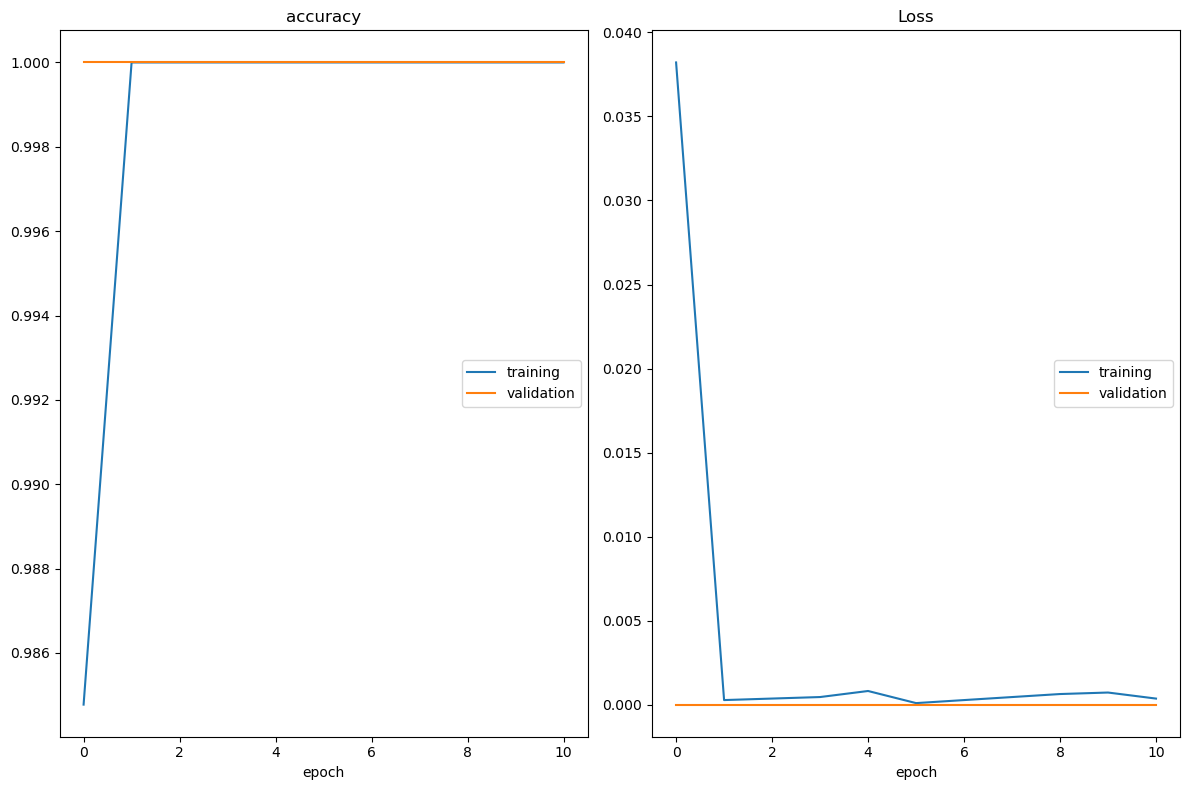

accuracy
	training         	 (min:    0.985, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.000, max:    0.038, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
60/60 [==============================] - 4s 71ms/step - loss: 3.5919e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
CPU times: user 48.9 s, sys: 7.47 s, total: 56.4 s
Wall time: 58.1 s


In [61]:
%%time

plot_loss_2 = PlotLossesCallback()

conv_history = conv_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [tl_checkpoint_1, early_stop, plot_loss_2],
                       verbose=1)


In [62]:
yp_train = conv_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = conv_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = conv_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

133/133 [==============================] - 0s 3ms/step


In [63]:
def confusion_matrix_train_test_val(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")

    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")


In [64]:
confusion_matrix_train_test_val("CNN", y_train, yp_train, y_val, yp_val, y_test, yp_test)


-----------------------------CNN-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15238

    accuracy                           1.00     15238
   macro avg       1.00      1.00      1.00     15238
weighted avg       1.00      1.00      1.00     15238

--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1694

    accuracy                           1.00      1694
   macro avg       1.00      1.00      1.00      1694
weighted avg       1.00      1.00      1.00      1694

--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4233

    accura

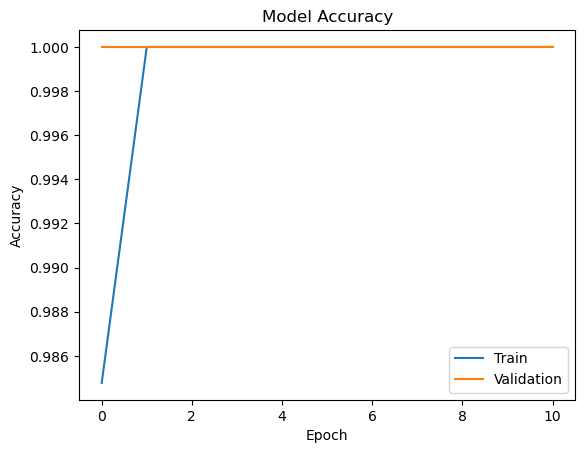

In [65]:
# Summarize History for Accuracy

plt.plot(conv_history.history['accuracy'])
plt.plot(conv_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()


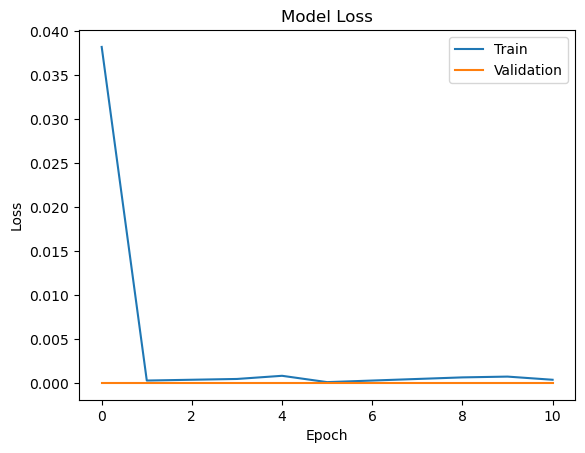

In [66]:
# Summarize History for Loss

plt.plot(conv_history.history['loss'])
plt.plot(conv_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()


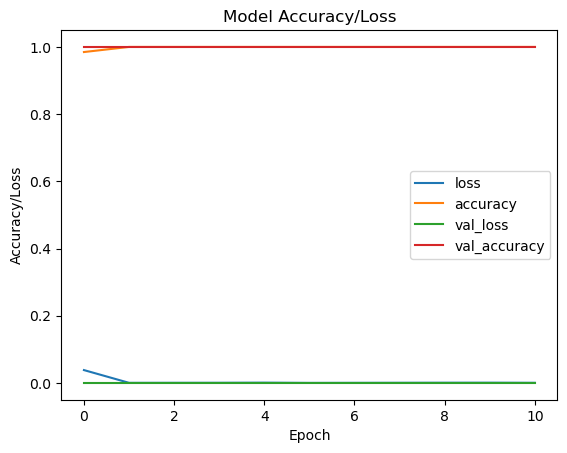

In [67]:
# Accuracy Loss Graph

pd.DataFrame(conv_history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()


In [68]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "block14_sepconv2_act"


In [71]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
import numpy as np

# Function to get image as numpy array
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)  # Add batch dimension
    return array

# Function to create Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Creating a model that gives us the last conv layer and the output
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Getting the predictions and the last convolutional layer output
        last_conv_layer_output, preds = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])  # If no index provided, take the top prediction
        
        class_channel = preds[:, pred_index]

    # Compute the gradients of the class channel with respect to the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Pool the gradients over all axes (height, width, channels)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the last conv layer output and compute the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)  # Remove single-dimensional entries
    
    # Normalize the heatmap: clip values and scale to [0, 1]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [72]:
# Storing Heatmap values into list

covid_noncovid_heatmap = []

for i in list_images_sample:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)


1/1 [==============================] - 1s 865ms/step


In [74]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.cm as cm
from tensorflow.keras.preprocessing import image

# Initialize list to store images for display
imag = []

# Function to save and display Grad-CAM output
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load and convert the input image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Convert the heatmap to an 8-bit integer representation
    heatmap = np.uint8(255 * heatmap)

    # Apply the 'jet' colormap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))  # Resize heatmap to match input image
    jet_heatmap = image.img_to_array(jet_heatmap)

    # Superimpose heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    # Save the result
    superimposed_img.save(cam_path)

    # Read the images into the list for display
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread(cam_path))  # Save unique path for each loop iteration

# Loop over the sample images and display the Grad-CAM output
for i in range(len(list_images_sample)):
    cam_path = f"cam_{i}.jpg"  # Unique path for each sample
    save_and_display_gradcam(list_images_sample[i], covid_noncovid_heatmap[i], cam_path)


In [75]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()


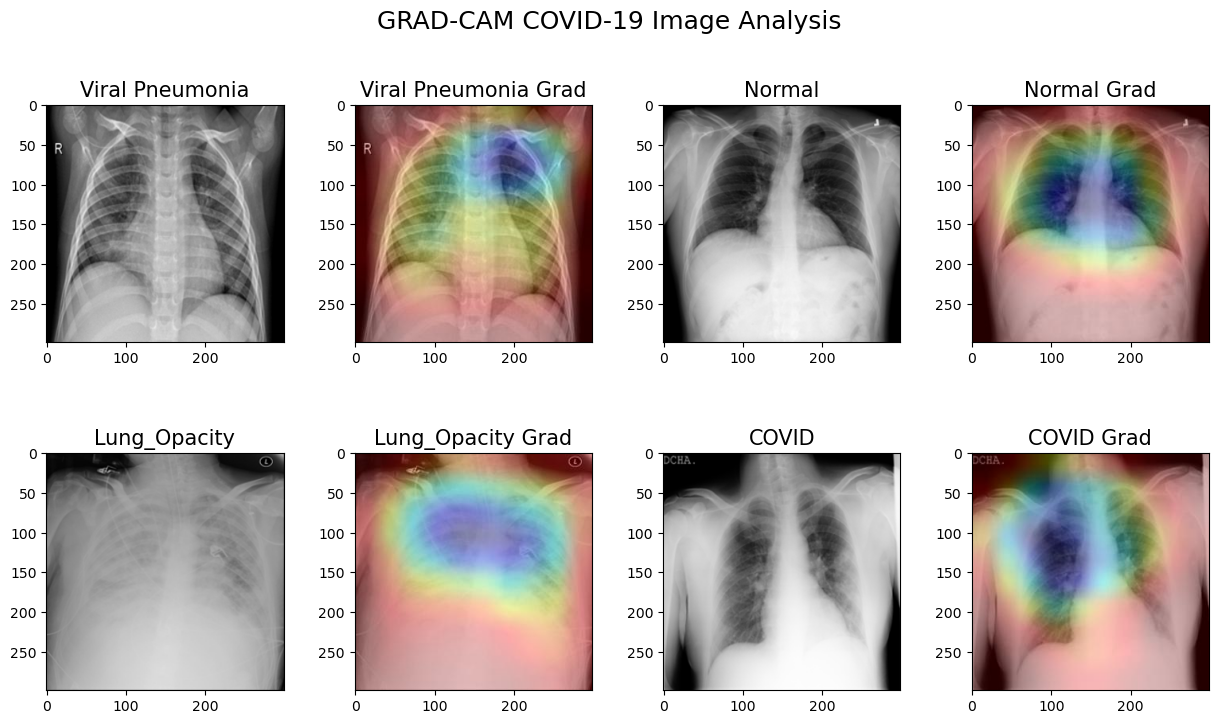

In [76]:
# list_images_sample = ["/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1003.png",
#                      "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10004.png",
#                      "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1000.png",
#                      "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1008.png"]

titles_list = ["Viral Pneumonia",'Viral Pneumonia Grad','Normal','Normal Grad','Lung_Opacity','Lung_Opacity Grad','COVID','COVID Grad']

plot_multiple_img(imag, titles_list, ncols = 4, main_title = "GRAD-CAM COVID-19 Image Analysis")
